In [20]:
import scipy.io
import os
from matplotlib import pyplot as plt
import cv2
from PIL import Image
import numpy as np
import json
from pprint import pprint
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import time
from collections import deque
import math

%matplotlib inline

In [97]:
seg_dir = '../data/lsun_room/layout_seg'
img_dir = '../data/lsun_room/images'
label_dir = '../data/lsun_room/layout_seg_images'
json_path = './type0_labels/via_region_data.json'
homes_dir = '../data/img_type_test_in'
label0_outdir = './type0_labels'

In [102]:
def get_meta(dataset_root, phase):
    phase = {'train': 'training', 'val': 'validation', 'test': 'testing'}[phase]
    mat = scipy.io.loadmat(os.path.join(dataset_root, f'{phase}.mat'))[phase][0]
    return [dict(name=m[0][0], scene=m[1][0], type=m[2][0][0], points=m[3], resolution=m[4][0]) \
            for m in mat if m[2][0][0] == 0]

type0 = [f for f in get_meta('../data/lsun_room', 'train')[:10]]
type0

[{'name': 'sun_buwbyujqbycgjcmd',
  'scene': 'conference_room',
  'type': 0,
  'points': array([[ 125.27296937,  288.89480692],
         [   0.        ,  158.50865513],
         [ 132.94274301, 1232.27696405],
         [   0.        , 1421.46471372],
         [1850.97203728, 1071.21171771],
         [2560.        , 1237.39014647],
         [1845.85885486,  334.91344874],
         [2560.        ,  224.98002663]]),
  'resolution': array([1920, 2560], dtype=uint16)},
 {'name': '87715fcb46adedcb2d0952a2bba7e51ff6267ab8',
  'scene': 'bedroom',
  'type': 0,
  'points': array([[224.29906542, 124.76635514],
         [ 29.78971963,   0.        ],
         [224.29906542, 292.64018692],
         [  0.        , 391.82242991],
         [477.68691589, 301.05140187],
         [600.        , 388.31775701],
         [478.03738318, 106.19158879],
         [569.1588785 ,   0.        ]]),
  'resolution': array([450, 600], dtype=uint16)},
 {'name': 'sun_asmbqvgwtdgpxipl',
  'scene': 'conference_room',
  't

In [107]:
def show_layout(type0):
    
    for n in type0:
        f = n['name']
        
        plt.figure(figsize=(15, 4))

        plt.subplot(131)
        layout = scipy.io.loadmat(os.path.join(seg_dir, '%s.mat' % f))['layout']
        plt.imshow(layout)

        plt.subplot(132)
        new_layout = Image.open(os.path.join(label_dir, '%s.png' % f))
        plt.imshow(np.asarray(new_layout))
        
        plt.subplot(133)
        img = Image.open(os.path.join(img_dir, '%s.jpg' % f))
        plt.imshow(img)

        plt.show()

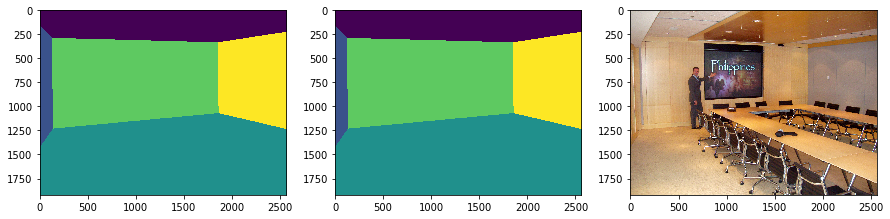

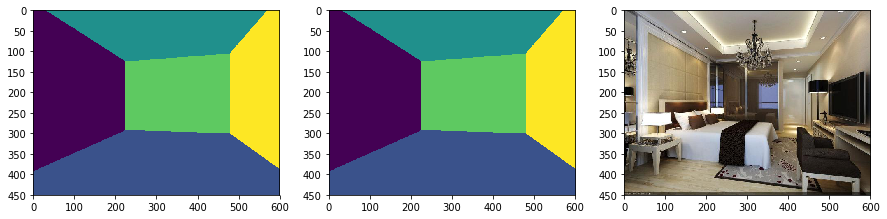

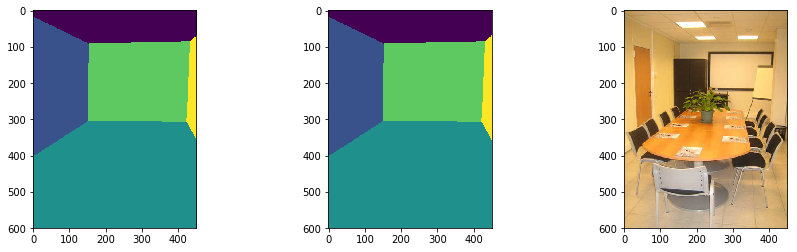

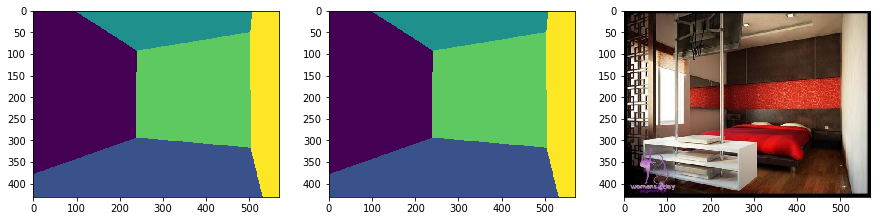

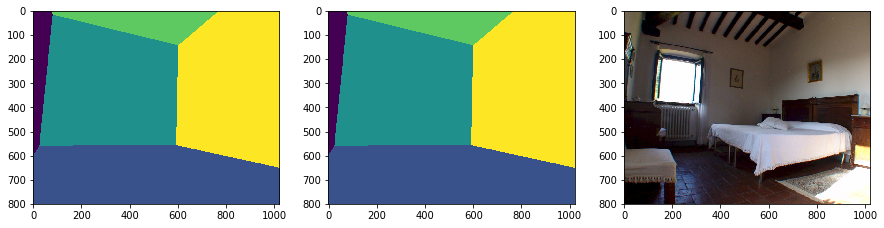

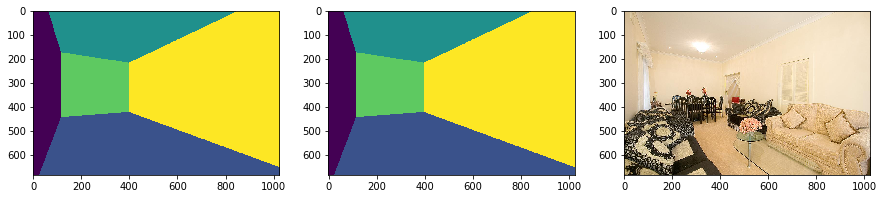

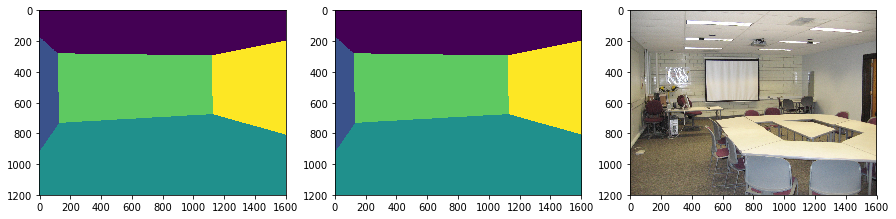

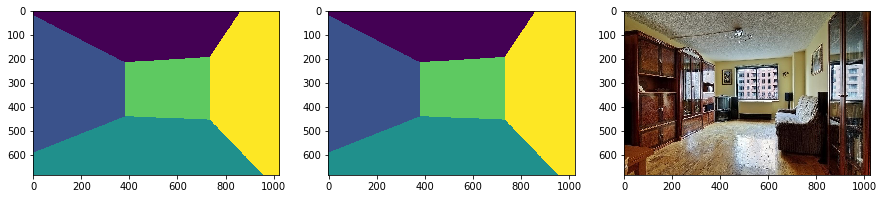

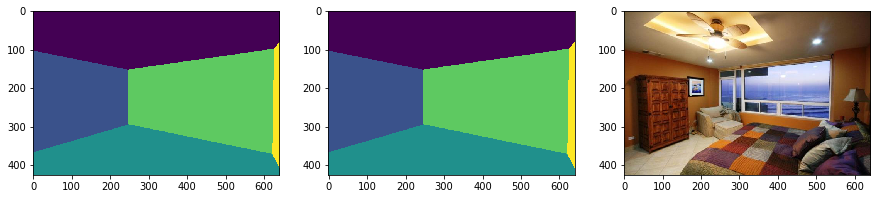

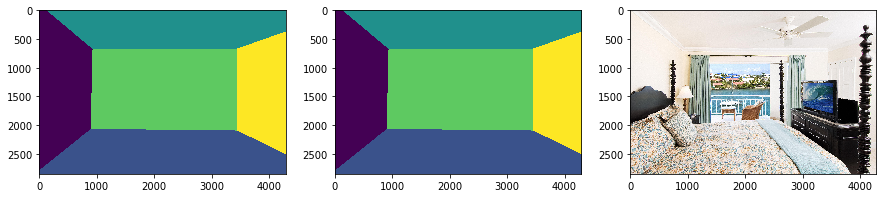

In [108]:
show_layout(type0)

In [93]:
def get_json(json_path):
    with open(json_path) as f:
        data = json.load(f)
    return data

def distance(x0, y0, x1, y1):
    return math.sqrt((x0-x1)**2 + (y0-y1)**2)

def inside_polygon(px, py, poly_xys):
    point = Point(px, py)
    polygon = Polygon(poly_xys)
    
    for i in range(len(poly_xys)):
        if abs(distance(*poly_xys[i-1], *poly_xys[i]) - \
            (distance(px, py, *poly_xys[i-1]) + distance(px, py, *poly_xys[i]))) < 0.0005:
            return True
        
    return polygon.contains(point)

18.jpg (425, 318, 3)
{1: (69, 42), 2: (15, 0), 3: (278, 43), 4: (302, 0), 5: (278, 253), 6: (325, 317), 7: (67, 243), 8: (0, 280)}
{2: [2, 4, 3, 1], 4: [4, 3, 5, 6, 'rb', 'lb'], 1: [1, 3, 5, 7], 3: [6, 5, 7, 8, 'ru'], 5: ['lu', 2, 1, 7, 8]}
assign labels:  22.866803407669067


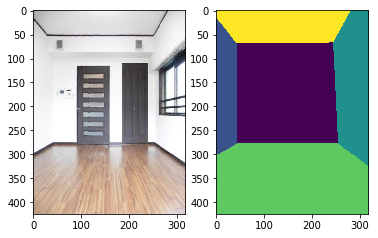

148.jpg (450, 600, 3)
{1: (48, 100), 2: (0, 67), 3: (325, 92), 4: (449, 36), 5: (315, 367), 6: (449, 537), 7: (109, 393), 8: (75, 599)}
{2: ['lu', 'lb', 4, 3, 1, 2], 4: [3, 4, 6, 5], 1: [1, 3, 5, 7], 3: [6, 5, 7, 8, 'rb'], 5: [1, 2, 'ru', 8, 7]}
assign labels:  49.08282518386841


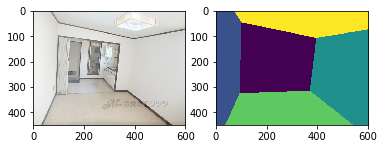

1250.jpg (600, 800, 3)
{1: (56, 74), 2: (0, 54), 3: (436, 97), 4: (599, 22), 5: (393, 454), 6: (526, 799), 7: (93, 453), 8: (0, 596)}
{2: ['lu', 'lb', 4, 3, 1, 2], 4: [4, 3, 5, 6, 'rb'], 1: [1, 3, 5, 7], 3: [6, 5, 7, 8, 'ru'], 5: [1, 2, 8, 7]}
assign labels:  86.61118459701538


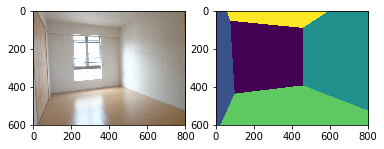

1990.jpg (425, 318, 3)
{1: (121, 52), 2: (95, 0), 3: (275, 56), 4: (308, 0), 5: (283, 283), 6: (334, 317), 7: (115, 293), 8: (81, 317)}
{2: [2, 4, 3, 1], 4: [4, 3, 5, 6, 'rb', 'lb'], 1: [1, 3, 5, 7], 3: [7, 5, 6, 8], 5: ['lu', 2, 1, 7, 8, 'ru']}
assign labels:  24.05184531211853


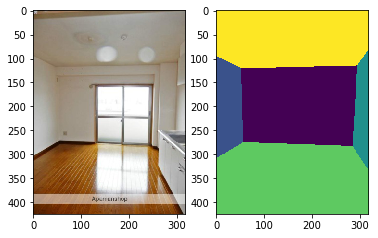

In [101]:
data = get_json(json_path)

for k, v in data.items():
    img_name = v['filename']
    if img_name in ['747.jpg']:
        continue
    img_pil = Image.open(os.path.join(homes_dir, img_name))
    img_arr = np.asarray(img_pil)
    img_height, img_width = img_arr.shape[0], img_arr.shape[1]
    
    print(img_name, img_arr.shape)
    plt.subplot(121)
    plt.imshow(img_arr)
    
    no2xy = {}
    for r in v['regions']:
        no = int(r['region_attributes']['No.'])
        
        xy = r['shape_attributes']
        x, y = int(xy['cx']), int(xy['cy'])
        
        # xy calibrations
        if no == 2:
            if x <= 5:
                x = 0
            if y <= 5:
                y = 0
        if no == 4:
            if x <= 5:
                x = 0
            if img_height-y <= 5:
                y = img_height-1
        if no == 6:
            if img_width-x <= 5:
                x = img_width-1
            if img_height-y <= 5:
                y = img_height-1
        if no == 8:
            if img_width-x <= 5:
                x = img_width-1
            if y <= 5:
                y = 0
        
        no2xy[no] = (y, x)
    print(no2xy)
    
    # polygon patterns of type 0
    poly_patterns = {2: [2, 4, 3, 1], # 2
                     4: [3, 4, 6, 5], # 3
                     1: [1, 3, 5, 7], # 4
                     3: [7, 5, 6, 8], # 5
                     5: [1, 2, 8, 7]} # 1
    
    # polygon pattern calibration
    no2xy['lu'], no2xy['lb'], no2xy['ru'], no2xy['rb'] = \
        (0, 0), (img_height - 1, 0), (0, img_width - 1), (img_height - 1, img_width - 1)

    if no2xy[2][0] == 0 and no2xy[8][0] == 0:
        pass
    elif no2xy[2][0] == 0 and no2xy[8][1] == img_width - 1:
        poly_patterns[5] = [1, 2, 'ru', 8, 7]
    elif no2xy[2][1] == 0 and no2xy[8][0] == 0:
        poly_patterns[5] = ['lu', 2, 1, 7, 8]
    elif no2xy[2][1] == 0 and no2xy[8][1] == img_width - 1:
        poly_patterns[5] = ['lu', 2, 1, 7, 8, 'ru']

    if no2xy[2][0] == 0 and no2xy[4][0] == img_height - 1:
        poly_patterns[2] = ['lu', 'lb', 4, 3, 1, 2]
    elif no2xy[2][0] == 0 and no2xy[4][1] == 0:
        poly_patterns[2] = ['lu', 4, 3, 1, 2]
    elif no2xy[2][1] == 0 and no2xy[4][0] == img_height - 1:
        poly_patterns[2] = [4, 3, 1, 2, 'lb']
    elif no2xy[2][1] == 0 and no2xy[4][1] == 0:
        pass

    if no2xy[6][0] == img_height - 1 and no2xy[4][0] == img_height - 1:
        pass
    elif no2xy[6][0] == img_height - 1 and no2xy[4][1] == 0:
        poly_patterns[4] = [4, 3, 5, 6, 'lb']
    elif no2xy[6][1] == img_width - 1 and no2xy[4][0] == img_height - 1:
        poly_patterns[4] = [4, 3, 5, 6, 'rb']
    elif no2xy[6][1] == img_width - 1 and no2xy[4][1] == 0:
        poly_patterns[4] = [4, 3, 5, 6, 'rb', 'lb']

    if no2xy[6][0] == img_height - 1 and no2xy[8][0] == 0:
        poly_patterns[3] = [6, 5, 7, 8, 'ru', 'rb']
    elif no2xy[6][0] == img_height - 1 and no2xy[8][1] == img_width - 1:
        poly_patterns[3] = [6, 5, 7, 8, 'rb']
    elif no2xy[6][1] == img_width - 1 and no2xy[8][0] == 0:
        poly_patterns[3] = [6, 5, 7, 8, 'ru']
    elif no2xy[6][1] == img_width - 1 and no2xy[8][1] == img_width - 1:
        pass
    
    print(poly_patterns)
    
    # assign pixel labels
    begin = time.time()
    label = np.zeros((img_arr.shape[0], img_arr.shape[1]), dtype=int)
    for x in range(label.shape[0]):
        for y in range(label.shape[1]):
            for k, v in poly_patterns.items():
                if inside_polygon(x, y, [no2xy[n] for n in v]):
                    label[x, y] = k
                    break
    print('assign labels: ', time.time() - begin)
    
    
    plt.subplot(122)
    plt.imshow(label)
    plt.show()
    assert(all(label.flatten()))
    
    plt.imsave(os.path.join(label0_outdir, img_name.replace('.jpg', '.png')), label)